## Enabling Import of Custom Python Modules from Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/EVA4')

In [0]:
import data_preprocess_module
import resnet
import train_test_module_CrossEntropy


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [0]:
from __future__ import print_function
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
%matplotlib inline
import matplotlib.pyplot as plt

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



### Using GPU instead of CPU

In [14]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


In [15]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform = data_preprocess_module.get_train_transform((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform = data_preprocess_module.get_test_transform((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))

trainloader, testloader = data_preprocess_module.get_train_test_loader(trainset, testset)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



plane   dog  deer  deer


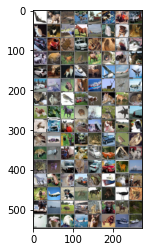

In [16]:
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [17]:
images.shape

torch.Size([128, 3, 32, 32])

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [18]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = resnet.ResNet18().to(device)
summary(net, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [19]:
def test():
    net = resnet.ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())
test()

torch.Size([1, 10])


In [20]:
from torch.optim.lr_scheduler import StepLR

net =  resnet.ResNet18().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=0.0005)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

EPOCHS = 25
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_test_module_CrossEntropy.train(net, device, trainloader, optimizer, epoch)
    scheduler.step()
    train_test_module_CrossEntropy.test(net, device, testloader)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.1199102401733398 Batch_id=390 Accuracy=44.20: 100%|██████████| 391/391 [00:30<00:00, 12.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -3.6545, Accuracy: 5523/10000 (55.23%)

EPOCH: 1


Loss=0.9163209199905396 Batch_id=390 Accuracy=65.39: 100%|██████████| 391/391 [00:30<00:00, 12.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.1756, Accuracy: 7080/10000 (70.80%)

EPOCH: 2


Loss=0.41204890608787537 Batch_id=390 Accuracy=74.53: 100%|██████████| 391/391 [00:30<00:00, 12.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -5.9805, Accuracy: 7349/10000 (73.49%)

EPOCH: 3


Loss=0.45076146721839905 Batch_id=390 Accuracy=79.38: 100%|██████████| 391/391 [00:30<00:00, 12.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.4564, Accuracy: 7866/10000 (78.66%)

EPOCH: 4


Loss=0.5062046647071838 Batch_id=390 Accuracy=82.62: 100%|██████████| 391/391 [00:30<00:00, 12.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.7542, Accuracy: 8117/10000 (81.17%)

EPOCH: 5


Loss=0.3680824935436249 Batch_id=390 Accuracy=84.88: 100%|██████████| 391/391 [00:30<00:00, 12.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.0973, Accuracy: 7870/10000 (78.70%)

EPOCH: 6


Loss=0.467451810836792 Batch_id=390 Accuracy=86.76: 100%|██████████| 391/391 [00:30<00:00, 12.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.7743, Accuracy: 7818/10000 (78.18%)

EPOCH: 7


Loss=0.28045716881752014 Batch_id=390 Accuracy=88.34: 100%|██████████| 391/391 [00:30<00:00, 12.76it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.8043, Accuracy: 8137/10000 (81.37%)

EPOCH: 8


Loss=0.4007633626461029 Batch_id=390 Accuracy=89.67: 100%|██████████| 391/391 [00:30<00:00, 12.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.4651, Accuracy: 7838/10000 (78.38%)

EPOCH: 9


Loss=0.16921289265155792 Batch_id=390 Accuracy=90.86: 100%|██████████| 391/391 [00:30<00:00, 12.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.7081, Accuracy: 8252/10000 (82.52%)

EPOCH: 10


Loss=0.2394467145204544 Batch_id=390 Accuracy=95.80: 100%|██████████| 391/391 [00:30<00:00, 12.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.8063, Accuracy: 8498/10000 (84.98%)

EPOCH: 11


Loss=0.08492077142000198 Batch_id=390 Accuracy=97.30: 100%|██████████| 391/391 [00:30<00:00, 12.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.7306, Accuracy: 8511/10000 (85.11%)

EPOCH: 12


Loss=0.08440825343132019 Batch_id=390 Accuracy=97.32: 100%|██████████| 391/391 [00:30<00:00, 12.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -10.3824, Accuracy: 8491/10000 (84.91%)

EPOCH: 13


Loss=0.1000223308801651 Batch_id=390 Accuracy=97.35: 100%|██████████| 391/391 [00:30<00:00, 12.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -10.1325, Accuracy: 8330/10000 (83.30%)

EPOCH: 14


Loss=0.19048765301704407 Batch_id=390 Accuracy=97.11: 100%|██████████| 391/391 [00:30<00:00, 12.77it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -10.2320, Accuracy: 8465/10000 (84.65%)

EPOCH: 15


Loss=0.14995543658733368 Batch_id=390 Accuracy=97.39: 100%|██████████| 391/391 [00:30<00:00, 12.79it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -10.1041, Accuracy: 8399/10000 (83.99%)

EPOCH: 16


Loss=0.08218203485012054 Batch_id=390 Accuracy=97.46: 100%|██████████| 391/391 [00:30<00:00, 12.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -10.1129, Accuracy: 8581/10000 (85.81%)

EPOCH: 17


Loss=0.14663895964622498 Batch_id=390 Accuracy=97.26: 100%|██████████| 391/391 [00:30<00:00, 12.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.6485, Accuracy: 8270/10000 (82.70%)

EPOCH: 18


Loss=0.15233170986175537 Batch_id=390 Accuracy=97.34: 100%|██████████| 391/391 [00:30<00:00, 12.77it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.8264, Accuracy: 8431/10000 (84.31%)

EPOCH: 19


Loss=0.08876778930425644 Batch_id=390 Accuracy=97.41: 100%|██████████| 391/391 [00:30<00:00, 12.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.4985, Accuracy: 8463/10000 (84.63%)

EPOCH: 20


Loss=0.020082199946045876 Batch_id=390 Accuracy=99.31: 100%|██████████| 391/391 [00:31<00:00, 12.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -10.0932, Accuracy: 8814/10000 (88.14%)

EPOCH: 21


Loss=0.014155810698866844 Batch_id=390 Accuracy=99.79: 100%|██████████| 391/391 [00:31<00:00, 12.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.9989, Accuracy: 8838/10000 (88.38%)

EPOCH: 22


Loss=0.007008939981460571 Batch_id=390 Accuracy=99.81: 100%|██████████| 391/391 [00:31<00:00, 12.54it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.8359, Accuracy: 8822/10000 (88.22%)

EPOCH: 23


Loss=0.0072037517093122005 Batch_id=390 Accuracy=99.88: 100%|██████████| 391/391 [00:30<00:00, 12.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.7684, Accuracy: 8886/10000 (88.86%)

EPOCH: 24


Loss=0.019072312861680984 Batch_id=390 Accuracy=99.90: 100%|██████████| 391/391 [00:30<00:00, 12.83it/s]



Test set: Average loss: -9.6707, Accuracy: 8861/10000 (88.61%)



5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



GroundTruth:    cat  ship  ship plane


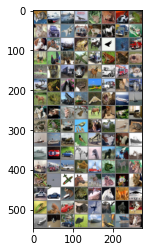

In [22]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [0]:
outputs = net(images.cuda())

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [24]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [25]:
correct = 0
total = 0
with torch.no_grad():
    for data, target in testloader:
        images, labels = data.to(device), target.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 88 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [26]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data, target in testloader:
        images, labels = data.to(device), target.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 93 %
Accuracy of   car : 100 %
Accuracy of  bird : 75 %
Accuracy of   cat : 82 %
Accuracy of  deer : 92 %
Accuracy of   dog : 87 %
Accuracy of  frog : 88 %
Accuracy of horse : 88 %
Accuracy of  ship : 96 %
Accuracy of truck : 92 %
